In [1]:
%load_ext watermark
import pandas as pd
import numpy as np
from typing import Type, Optional, Callable
from typing import List, Dict, Union, Tuple

import sklearn.linear_model
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import RANSACRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

import scipy.stats as stats
import statsmodels.api as sm

import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.colors
from matplotlib.colors import LinearSegmentedColormap, ListedColormap
import seaborn as sns

import setvariables as conf_
import reportclass as r_class

# Land use class

The LandUse class takes the land-use, land-cover and streets data and merges them to a single dataframe where the index is the survey location and the columns are the scaled values of the attributes measured in QGIS. The land-cover and land-use data is given as a % of the available dry land attributed to a specific label. The streets are given as the length in meters.

The default scaling method is Min-Max:

```python
def scale_a_column(df: pd.DataFrame, column_to_scale: str, column_name: str = 'length'):    

    # Calculate the minimum and maximum values in the column
    min_value = df[column_to_scale].min()
    max_value = df[column_to_scale].max()

    # Perform min-max scaling on a temp column
    df['scalex'] = (df[column_to_scale] - min_value) / (max_value - min_value)
    # reassign the value
    df[column_name] = df['scalex']
    # drop the temp
    df.drop('scalex', axis=1, inplace=True)
    return df
```

## Why is this important?

__Because it is another way to get proxies for usage and population.__

We assume there is a relationship between how the land is used and what it is we find on the ground. Archeaologists and Anthropologists make this basic assumption every time they undertake an excavation and interpret the results in the context of other findings. This interpretation of beach litter data does exactly the same. As discussed in [Near or far](https://www.hammerdirt.ch) and the federal report [IQAASL](https://www.hammerdirt.ch) at the national level there is strong evidence to support a correlation between the density of objects found and specific topographic features that can be isolated on a standard topographical map.

## What is important?

__The relationship between the topograhpical features and the density of the objects found and scale at which that relationship is described.__

However, the measured features are not independent of each other. For example if their are buildings in an area we expect to also find a road that leads to those buildings. This multicolinearity can lead to unstable coefficient estimates and make it challenging to interpret the individual effects of the correlated variables on the target variable.

The scale for which the results are valid is important for planning purposes. We consider that the scale of the use of the data should be comparable to the scale of the lowest administrative unit that is responsible. It may be tempting to look at this as a rating to system. Thus pointing the finger at the locations that have the highest density. It may be better to interpret this as a list to help prioritise resource allocation.

__The reliability and the continuity of the data and analysis.__

The collected data is a diverse combination of different interpretations of the same protocol. The reasons for this is because there is no _centralized authority_ that requires the data be collected in a specific way. The basic assumption is that all stakeholders did the best they could within the limits of the resources at hand and the experience of their respective teams. From this we conclude that the surveys are a resonable description of the minimum number of objects found at the defined survey location within the limits of the length recorded. There are many ways that survey consistency can improve, the easiest and fastet is: i. Defining a standard method, ii. allocating resources to collect the data using the defined method. 

The topographical data from the confederation provides continuity to what could be interpreted as unrelated observations. Furthermore, the labels provided for the various topographical features are indicators of use and have a real meaning to georaphers and engineers in planning and development. Local associations that are involved in preventing and reducing litter may also be interested.

To start a `LandUse class`, first intiate a `ReportClass` for the boundaries of interest. In this example all lakes have been selected for all results between 2015 and 2022.

```python
# ! USER DEFINED INPUT
# Temporal and geographic boundaries.
boundaries = dict(feature_type='l', language='fr', start_date='2015-01-01', end_date='2022-01-01')

# Make the report data and report
top_label, language, w_df, w_di = r_class.report_data(boundaries, survey_data.copy(), beaches, codes)
a_report = r_class.ReportClass(w_df, w_di, boundaries, top_label, 'fr', c_l)
```

The locations from the ReportClass are used to select the relevant geo-data. Survey locations that have no geo-data are dropped from the analysis, a list of dropped locations is produced. 

```python
# start land use class
w_df_locations = w_df.slug.unique()

# call the land use class on the two different location groups
m_ui = LandUse(land_cover, land_use, streets, w_df_locations)

# make a copy of the land use data
lcui = m_ui.use_of_land.copy()

# identify locations with no topo data and merge
# the results to the available topo data that means
# the locations with no topo data will not be considered
# in the analysis
lc_sti, no_datai = match_topo_attributes_to_surveys(lcui, a_report.w_df)
```
Merge the validated geo-data with the survey results and scale the pcs_m column of the survey data.

```python

# the basic work data contains the survey results and the 
# topographical data merged on the <slug> column
work_data_i = merge_topodata_and_surveydata(lc_sti, a_report.w_df)

# we are interested in the most common objects from the region of interest
# select the most common codes from the report class
# w_data_mc = work_data_i[work_data_i.code.isin(a_report.most_common.index)].copy()

# select an object from the most common:
selected = ["G27"]
w_datai = work_data_i[work_data_i.code.isin(selected)].copy()
w_datai = scale_a_column(w_datai, column_to_scale='pcs_m', column_name="scaled")
```
The code for the LandUse class is below:

In [2]:

def match_topo_attributes_to_surveys(topo_data: pd.DataFrame, survey_data: pd.DataFrame)-> Tuple[pd.DataFrame,List]:
    """
    Match topographic attributes to survey data for specific locations.

    This function takes topographic attribute data and survey data and matches them based on the unique locations (slugs).
    
    Parameters:
        topo_data (pd.DataFrame): A DataFrame containing topographic attribute data.
        survey_data (pd.DataFrame): A DataFrame containing survey data.

    Returns:
        Tuple[pd.DataFrame, List]: A tuple containing two elements:
            - A DataFrame containing topographic attribute data for locations found in both datasets.
            - A list of locations (slugs) from the survey data for which there is no matching topographic data.

    """

    locations = survey_data.slug.unique()
    available = topo_data.index
    no_data = [x for x in locations if x not in available]
    locations_with_data = [x for x in locations if x in available]
    
    return topo_data.loc[locations_with_data], no_data

def merge_topodata_and_surveydata(topo, surveys, columns: List[str] = conf_.work_columns)-> pd.DataFrame:
    """
    Merge survey data with topographic data using location information.

    This function merges survey data with topographic data using the 'slug' column in the survey data
    and the index of the topographic data. The merged DataFrame will contain the specified columns from the survey data.

    Parameters:
        topo (pd.DataFrame): A DataFrame containing topographic data with the location index.
        surveys (pd.DataFrame): A DataFrame containing survey data with a 'slug' column for location matching.
        columns (List[str]): A list of column names to include in the merged DataFrame (default is defined in conf.work_columns).

    Returns:
        pd.DataFrame: A merged DataFrame containing the specified survey data columns and topographic data.
    """
    # merges surveys to topo using the slug column in surveys
    # and the index in topo
    return surveys[columns].merge(topo, left_on='slug', right_index=True)

def scale_a_column(df: pd.DataFrame, column_to_scale: str, column_name: str = 'length'):    

    # Calculate the minimum and maximum values in the column
    min_value = df[column_to_scale].min()
    max_value = df[column_to_scale].max()

    # Perform min-max scaling on a temp column
    df['scalex'] = (df[column_to_scale] - min_value) / (max_value - min_value)
    # reassign the value
    df[column_name] = df['scalex']
    # drop the temp
    df.drop('scalex', axis=1, inplace=True)
    return df

def group_topographic_attributes(df: pd.DataFrame, list_of_labels: List = None, locations: List = None, coi: str = 'scale')-> pd.DataFrame:
    """
    Group and aggregate topographic attributes in a DataFrame.

    This function groups and aggregates topographic attributes in the provided DataFrame. You can specify a list of labels
    to group attributes, filter locations, and choose the column of interest for aggregation.

    Parameters:
        df (pd.DataFrame): A DataFrame containing topographic attributes.
        list_of_labels (List, optional): A list of dictionaries with keys as new attribute names and values as properties to group.
        locations (List, optional): A list of locations to filter the data (default is None, no location filtering).
        coi (str, optional): The column of interest for aggregation (default is 'scale').

    Returns:
        pd.DataFrame: A DataFrame with aggregated topographic attributes based on the specified grouping and filtering.
   """
    
    if locations is not None:
        df = df.loc[df.slug.isin(locations)]    
    # list of labels is a list of dictionaries
    if list_of_labels is not None:
        for new_labels in list_of_labels:
            # the attributes, the dictionary values are 
            # properties being grouped
            attributes = list(new_labels.values())
            # the dictionary key is the new name of
            # the attributes in the list
            new_val = list(new_labels.keys())
            df.loc[df['attribute'].isin(attributes[0]), 'attribute'] = new_val[0]
    # sum the new attributes
    r = df.groupby(['slug','attribute'], as_index=False)[coi].sum()

    # pivot and set the index to the locations
    # have the attributes
    r = r.pivot(columns='attribute', index='slug')            
            
    return r.droplevel(0, axis=1).fillna(0)

class LandUse:
    """
    A class for analyzing and transforming land use data.

    This class provides methods to analyze land cover, land use, and transportation data.
    It allows you to group attributes, scale data, and create ordinal rankings based on quantiles.

    Parameters:
        land_cover (pd.DataFrame): DataFrame containing land cover data.
        land_use (pd.DataFrame): DataFrame containing land use data.
        transportation (pd.DataFrame): DataFrame containing transportation data.
        locations (List): List of locations for filtering data.
        street_groups (List, optional): List of street groups (default is from configuration).
        land_use_groups (List, optional): List of land use groups (default is from configuration).

    Attributes:
        quantiles (List): List of quantile values for ordinal ranking.
        labels (List): List of labels corresponding to quantile groups.

    Properties:
        - land_cover: Grouped and aggregated land cover data.
        - land_use: Grouped and aggregated land use data.
        - trans: Grouped and aggregated transportation data.
        - use_of_land: Combined data with the option to scale the columns between 0 and 1.
        - ordinal_land_rank: Ordinal ranking based on quantiles for land use data.

    Example:
        land_use_data = LandUse(land_cover_data, land_use_data, transportation_data, locations)
        land_cover = land_use_data.land_cover
        land_use = land_use_data.land_use
        trans_data = land_use_data.trans(new_labels=[{'new_attr': ['attr1', 'attr2']}])
        land_rankings = land_use_data.ordinal_land_rank
    """
    street_groups = conf_.street_groups
    land_use_groups = conf_.lu_groups

    def __init__(self, land_cover, land_use, transportation, locations, street_groups=street_groups, land_use_groups=land_use_groups):
        self.lc = land_cover
        self.lu = land_use
        self.tr = transportation
        self.locations = locations
        self.lug = land_use_groups
        self.stg = street_groups
        self.quantiles = [0.0, 0.03, 0.25, 0.75, 0.97, 1.0]
        self. labels = ['lowest', 'low', 'middle', 'high', 'highest']
        
    @property
    def land_cover(self, list_of_labels=None):
        return group_topographic_attributes(self.lc, locations=self.locations, list_of_labels=list_of_labels)

    @property
    def land_use(self, new_labels=None):
        if new_labels is not None:
            return group_topographic_attributes(self.lu, locations=self.locations, list_of_labels=new_labels)
        else:
            return group_topographic_attributes(self.lu, locations=self.locations, list_of_labels=self.lug)
    
    @property
    def trans(self,new_labels=None):
        if new_labels is not None:
            return group_topographic_attributes(self.tr, locations=self.locations, list_of_labels=new_labels, coi='length')
        else:
            return group_topographic_attributes(self.tr, locations=self.locations, list_of_labels=self.stg, coi='length')

    @property
    def use_of_land(self, scaled: bool = True):
        a = self.land_cover.merge(self.land_use, left_index=True, right_index=True)
        b = a.merge(self.trans, left_index=True, right_index=True)
        
        if scaled:
            self.scaler = MinMaxScaler()
            scaled_data = self.scaler.fit_transform(b)
            b = pd.DataFrame(scaled_data, columns=b.columns, index=b.index)
        return b
    
    @property
    def ordinal_land_rank(self):
        ranked_df = self.use_of_land.copy()
        columns_to_rank = ranked_df.columns
        for column in columns_to_rank:
            label = f'{column}_ordinal_rank'
            ranked_df[label] = pd.cut(ranked_df[column], bins=self.quantiles, labels=self.labels, include_lowest=True)
            ranked_df[column] = ranked_df[label]
            ranked_df.drop(label, inplace=True, axis=1)
        return ranked_df

In [3]:
# Collecting required data to establish a report
# This includes the language maps for all the common
# abbreviations and columns or index labels.
c_l = r_class.language_maps()

# The survey data in units of pcs/m or pcs/m². The reports
# are aggregated first to the sample_id. Which means that the operations
# are the same wether using pcs/m or pcs/m².
surveys = r_class.collect_survey_data_for_report()

# The support or evnvironmental data. This includes plain text descriptions 
# of the Codes. Details for each survey location and topogrphical data
# extracted from the buffer around each survey location.
codes, beaches, land_cover, land_use, streets, river_intersect_lakes = r_class.collect_env_data_for_report()

# Add columns to survey data. The support data contains information that can be used to
# group objects or survey locations that may not be stored with the survey data. In this
# example an adiminstrative label is attached to each survey_id. The cantonal label:
survey_data = surveys.merge(beaches['canton'], left_on='slug', right_index=True, validate='many_to_one')
survey_data = survey_data.loc[survey_data.code == 'G27'].copy()
survey_data = survey_data[survey_data.feature_name != 'aare'].copy()

# ! USER DEFINED INPUT
# Temporal and geographic boundaries.
boundaries = dict(feature_type='l', language='fr', start_date='2015-01-01', end_date='2022-01-01')

# Make the report data and report
top_label, language, w_df, w_di = r_class.report_data(boundaries, survey_data.copy(), beaches, codes)
a_report = r_class.ReportClass(w_df, w_di, boundaries, top_label, 'fr', c_l)

# start land use class
w_di_locations = w_di.slug.unique()
w_df_locations = w_df.slug.unique()

# call the land use class on the two different location groups
m_ui = LandUse(land_cover, land_use, streets, w_df_locations)
m_uo = LandUse(land_cover, land_use, streets, w_di_locations)

# for the region of interest
lcui = m_ui.use_of_land.copy()
# for all regions
lcuo = m_uo.use_of_land.copy()

# identify locations with no topo data and merge
# the results to the available topo data that means
# the locations with no topo data will not be considered
# in the analysis
lc_sti, no_datai = match_topo_attributes_to_surveys(lcui, a_report.w_df)
lc_sto, no_datao = match_topo_attributes_to_surveys(lcuo, a_report.w_di)

# the basic work data contains the survey results and the 
# topographical data merged on the <slug> column
work_data_i = merge_topodata_and_surveydata(lc_sti, a_report.w_df)
work_data_o = merge_topodata_and_surveydata(lc_sto, a_report.w_df)

# we are interested in the most common objects from the region of interest
# select the most common codes from the report class
# w_data_mc = work_data_i[work_data_i.code.isin(a_report.most_common.index)].copy()

# select an object from the most common:
selected = ["G27"]
w_datai = work_data_i[work_data_i.code.isin(selected)].copy()
w_datai = scale_a_column(w_datai, column_to_scale='pcs_m', column_name="scaled")

w_datao = work_data_o[work_data_o.code.isin(selected)].copy()
w_datao = scale_a_column(w_datao, column_to_scale='pcs_m', column_name="scaled")

In [4]:
a_report.summarize_feature_labels('feature_name')

pcs_m                                                       \
label bielersee  bodensee brienzersee greifensee katzensee lac-leman   
25%        0.03      0.09         0.0       0.33    0.4875      0.14   
50%        0.06      0.17        0.06      0.745      0.74      0.66   
75%        0.43    0.3075         1.0     1.1775    0.8675      1.59   
count        51        28           5         34        12       249   
max        3.23       1.1        1.37       9.38      2.78      19.7   
mean   0.490392  0.241071       0.486   1.284706  0.941667  1.351245   
min         0.0      0.03         0.0        0.0      0.38       0.0   
std    0.860404  0.245226    0.651828   1.810343  0.739814  2.156339   
total       845       307         102       2007       711     13925   

                                                                             \
label lago-di-lugano lago-maggiore neuenburgersee quatre-cantons sempachsee   
25%            1.215          0.07           0.03            0.0       0.09   
50%             2.42         0.095           0.18           0.03       0.25   
75%            4.925        0.3675         0.3225          0.075       0.31   
count              4            18             52             35         11   
max            10.04          3.85            3.1           0.37       1.25   
mean            3.72      0.437222       0.326731          0.056   0.344545   
min              0.0          0.02            0.0            0.0        0.0   
std         4.413646      0.892022        0.51681       0.093469   0.431355   
total            389           312            958            114         61   

                                                         
label thunersee  untersee  walensee  zugersee zurichsee  
25%       0.065      0.37     0.145      0.11       0.2  
50%        0.14      0.76      0.29     0.165      0.54  
75%        0.31      0.94      1.07       0.8      1.36  
count        43         6        42        24       141  
max        1.42      1.64      3.31      1.69      7.62  
mean   0.259767  0.773333  0.757381  0.474167  1.086383  
min         0.0      0.24       0.0       0.0       0.0  
std    0.323813  0.518253  0.979425  0.531781  1.480187  
total       695       116      1151       387      6953

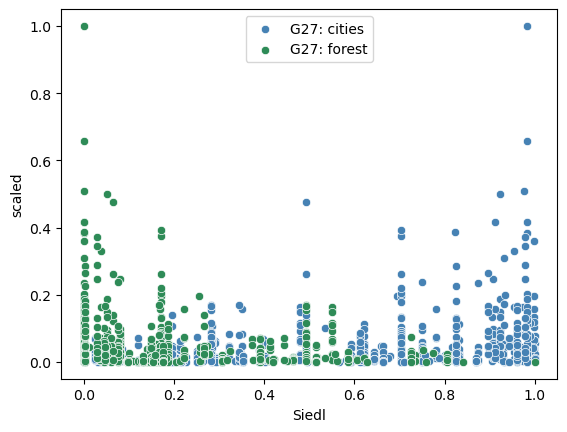

In [5]:
fig, ax = plt.subplots()

sns.scatterplot(data=w_datai, x='Siedl', y='scaled', c='steelblue', label='G27: cities')
sns.scatterplot(data=w_datai, x='Wald', y='scaled', c='seagreen', label='G27: forest')

plt.show()

In [6]:
m_ui.ordinal_land_rank

attribute,Obstanlage,Reben,Siedl,Wald,undefined,land_use,streets
slug,,,,,,,
aabach,lowest,lowest,low,middle,middle,lowest,low
anarchy-beach,lowest,lowest,highest,lowest,lowest,low,low
arabie,lowest,low,high,lowest,lowest,low,middle
ascona-traghetto-spiaggia,lowest,lowest,middle,middle,low,low,middle
augustmutzenbergstrandweg,lowest,low,middle,low,low,low,low
...,...,...,...,...,...,...,...
zugerseecholler_cham_blarerm,lowest,lowest,middle,lowest,middle,low,middle
zurcher-strand,lowest,lowest,high,lowest,low,middle,highest
zurichsee-feldeggstr-banningersand,lowest,lowest,high,lowest,low,middle,middle


Locations with no landuse data are excluded.

## Correlation of independent variables

### Definition of significant correlations

The p value of the Pearson correlation coefficient is used to decide whether or not a correlation is of interest. The default threshold is set at 0.05, the absolute value of the correlation is another threshold that can be changed. 

```python
# the topographical feautures
X = w_data[lcu.columns]

# scaled result of pcs/m
y = w_data.scale

# the correlation matirx of
# of the topogrphical features
X_corr = X.corr()

   
significant = find_significant_correlations(X, threshold=0.4, p_value_threshold=0.05)
```
__The significant correlations:__

In [7]:
def find_significant_correlations(df: pd.DataFrame, threshold: float = 0.4, p_value_threshold: float = 0.05, func: Callable = stats.pearsonr) -> List[Tuple[str, str]]:
    """
    Find significant correlations in a DataFrame.

    Parameters:
        df (pd.DataFrame): The input DataFrame containing the data.
        threshold (float): The threshold for the absolute correlation coefficient (default is 0.7).
        p_value_threshold (float): The p-value threshold for significance (default is 0.05).
        func (Callable): The correlation method from scipy.stats

    Returns:
        List[Tuple[str, str]]: A list of significant correlations as tuples of column labels.

    Example:
        data = {
            'A': np.random.rand(100),
            'B': np.random rand(100),
            'C': np.random rand(100),
        }
        df = pd.DataFrame(data)
        significant_correlations = find_significant_correlations(df)
        print(significant_correlations)
    """
    # Calculate the correlation matrix
    X_corr = df.corr().values

    # Calculate the p-values for each correlation coefficient
    n = len(df)
    p_values = np.empty_like(X_corr)
    for i in range(X_corr.shape[0]):
        for j in range(i + 1, X_corr.shape[1]):
            corr, p_value = func(df.iloc[:, i], df.iloc[:, j])
            p_values[i, j] = p_value

    # Mask the diagonal by setting it to NaN
    np.fill_diagonal(X_corr, np.nan)

    # Create a mask to filter out correlations with p-values less than p_value_threshold
    mask = p_values < p_value_threshold

    # Find significant correlations using NumPy operations
    significant_i, significant_j = np.where(mask & (np.abs(X_corr) > threshold))

    # Get the index and column labels of significant correlations
    significant_correlations = [(df.columns[i], df.columns[j]) for i, j in zip(significant_i, significant_j)]

    # Remove duplicates with values in different orders
    unique_correlations = set(tuple(sorted(correlation)) for correlation in significant_correlations)


    return np.array(list(unique_correlations)), mask

def combining_and_interacting(df: pd.DataFrame = None, cols: tuple = None, combining: bool=True, i: int = None)-> pd.DataFrame:
    if i is not None:
        label = f'{i}_{cols[0]}'
    else:
        label = '_'.join(cols)
    if combining is True:
        df[label] = df[cols].sum(axis=1)
    else:
        df[label] = df[cols].product(axis=1)
    

def combine_or_multipy_column_values(df, significant, func: Callable = combining_and_interacting, **kwargs):
    
    for i, a_pair in enumerate(significant):
        func(df, a_pair, i=i, **kwargs)
    return df

In [8]:
# the topographical feautures
features = w_datai[lcui.columns].copy()

# scaled result of pcs/m
target = w_datai.scaled

# the correlation matirx of
# of the topogrphical features
X_corr = features.corr()

f_s_c, mask_paired = find_significant_correlations(features)
f_s_c

array([['Siedl', 'Wald'],
       ['streets', 'undefined'],
       ['Siedl', 'streets'],
       ['Siedl', 'undefined'],
       ['Siedl', 'land_use'],
       ['land_use', 'streets'],
       ['land_use', 'undefined']], dtype='<U9')

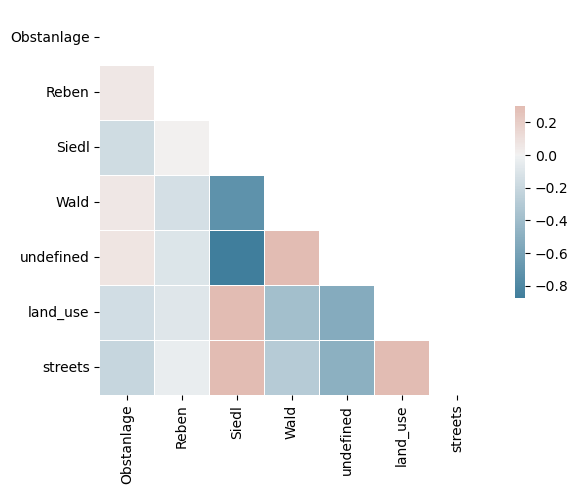

In [9]:
mask = np.triu(np.ones_like(X_corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(8, 5))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(X_corr, mask=mask, cmap=cmap, vmax=.3, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

There are some standard methods that can be used to reduce the effects of multicolinearity. Some of these methods happen before applying a regression model and some are part of the regression model. 

__Before running regression:__

This is a function of the ReportClass and LandUse class. Both classes have methods to pass different combinations of columns. The columns are the feauture variables from the LandUse class. The target variable can be parameterized in the ReportClass. The LandUse class is dependent on the ReportClass for the list of locations.
1. Variable selection:  select a subset of the correlated variables based on domain knowledge or theoretical understanding of the problem. Choose the variables that are most relevant to the target variable and exclude the others.
2. Combine variables: If the correlated variables measure similar aspects of the phenomenon you are studying, you can consider creating a composite variable by averaging or summing them. This can help reduce multicollinearity and provide a more interpretable model.
3. Interaction terms: Interaction terms can be created by multiplying the correlated variables together and including these terms in the regression model.

The default value for the land use data is everything is aggregated to the top-level group. However, all subgroups from the original layer are available for grouping.

__Regression:__

1. Regularization techniques: Ridge regression and Lasso regression are designed to handle multicollinearity. Ridge regression adds a penalty term to the loss function that shrinks the coefficients of correlated variables, making them more stable. Lasso regression not only shrinks coefficients but can also set some of them to exactly zero, effectively selecting a subset of variables.
5. Principal component analysis (PCA): PCA transforms the original variables into a set of uncorrelated variables (principal components). You can then use these components in your regression model. PCA can be effective when the multicollinearity is high and you want to retain most of the variance explained by the correlated variables.


### Variable selection and combination

#### Combination

The land-use variables have been combined by use. We have defined five use cases:

1. non-technical: places where people go. Sports, outdoor parks, Nurseries, cemeteries
2. extraction: areas where mining is permitted
3. technical: electrical substations, trash-dumps, trash incineration, water-treatment, antennae
4. services: hospitals, schools, prisons, military parade grounds

The streets are combined in the same fashion. The following code is used to implement those groups based on the map-label:

```python

# land_uses_grouped:
# outdoor non technical use:
lu_non_tech = {'places': ['Friedhof', 'Hitorisches Areal', 'Schrebergartenareal', 'Oeffentliches Parkareal', 'Messeareal', 'Klosterareal',  'Wald nicht bestockt', 'Baumschule']}
# waste-water-treatment, power, mining etc...
lu_technical = {'technical':['Kehrichtverbrennungsareal', 'Deponieareal', 'Deponieareal', 'Abwasserreinigungsareal','Unterwerkareal', 'Antennenareal', 'Kraftwerkareal', 'Kiesabbauareal', 'Steinbruchareal',  'Lehmabbauareal']}
# services:
lu_services = {'services': ['Massnahmenvollzugsanstaltsareal', 'Schul- und Hochschulareal', 'Spitalareal', 'Historisches Areal', 'Truppenuebungsplatz']}

# this combines the all into land_use:
lu_combined = {'land_use':[*list(lu_non_tech.keys()), *list(lu_technical.keys()), *list(lu_services.keys())]}

lu_groups = [lu_non_tech,lu_technical, lu_services, lu_combined]

# streets grouped
# surface streets residential areas
str_surface = {'surface streets':['NebenStr3', 'NebenStr6']}
str_ped_br = {'pedestrian': ['Fahrstraes', 'Fussweg']}
str_main = {'principal': [ 'HauptStrAB6', 'VerbindStr4','VerbindStr6', 'HauptStrAB4', 'NebenStr6']}
str_auto = {'highways': ['Autobahn', 'Autostr', 'Autob_Ri']}

# this combines them all into streets
str_combined = {'streets':['surface streets', 'pedestrian', 'principal', 'highways']}

street_groups = [str_surface, str_ped_br, str_main, str_auto, str_combined]
```

## Linear regression models

The purpose of collecting the topographic data is to understand the relationship between the density of objects observed and the physical environment they are observed in (the conditions of the observation).

### Random Sample Consensus (RANSAC)

From [scikit-learn]('https://scikit-learn.org/stable/modules/linear_model.html#robustness-regression-outliers-and-modeling-errors')

RANSAC (RANdom SAmple Consensus) fits a model from random subsets of inliers from the complete data set.

RANSAC is a non-deterministic algorithm producing only a reasonable result with a certain probability, which is dependent on the number of iterations (see max_trials parameter). It is typically used for linear and non-linear regression problems and is especially popular in the field of photogrammetric computer vision.

The algorithm splits the complete input sample data into a set of inliers, which may be subject to noise, and outliers, which are e.g. caused by erroneous measurements or invalid hypotheses about the data. The resulting model is then estimated only from the determined inliers.

In [10]:
def median_absolute_deviation(data):
    return np.median(np.abs(data - np.median(data)))

def model_eval(y_test, y_test_pred):
    mse_test = mean_squared_error(y_test, y_test_pred)
    r_squared = r2_score(y_test, y_test_pred)
    return {'MSE': mse_test, 'r²':r_squared}

def collect_model_results(model_name, y_test, y_test_pred, **kwargs):
    performance = model_eval(y_test, y_test_pred)
    return {model_name: performance}

df_oi = features.copy()
y = target.copy()
    
model_performance = []
X_train, X_test, y_train, y_test = train_test_split(df_oi, y, test_size=0.3, random_state=1)
r_t = median_absolute_deviation(y)
ransac = RANSACRegressor(LinearRegression(), max_trials=1000, min_samples=0.8, residual_threshold=r_t*20, random_state=42)
ransac.fit(X_train, y_train)
y_train_pred = ransac.predict(X_train)
y_test_pred = ransac.predict(X_test)
model_performance.append(collect_model_results('RANSAC-Linear', y_test, y_test_pred))

In [11]:
ransac

RANSACRegressor(estimator=LinearRegression(), max_trials=1000, min_samples=0.8,
                random_state=42, residual_threshold=0.3147208121827411)

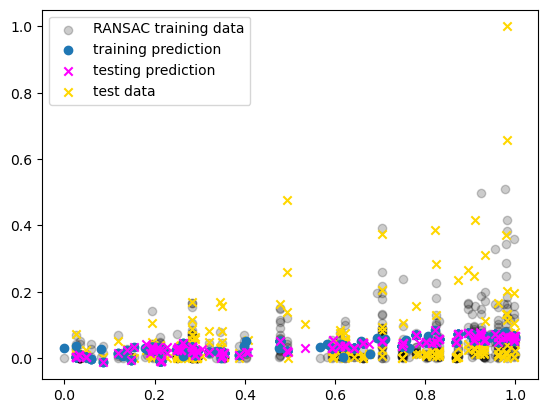

In [12]:
plt.scatter(X_train['Siedl'], y_train, label='RANSAC training data', color='black', alpha=0.2, zorder=0)
plt.scatter(X_train['Siedl'], y_train_pred,  label='training prediction', zorder=1)
plt.scatter(X_test['Siedl'], y_test_pred, label='testing prediction', marker='x', color='magenta', zorder=2)
plt.scatter(X_test['Siedl'], y_test, label='test data', marker='x', color='gold', zorder=0)
plt.legend()
plt.show()

### Polynomial regression

From [scikit-learn](https://scikit-learn.org/stable/modules/linear_model.html#polynomial-regression-extending-linear-models-with-basis-functions)

One common pattern within machine learning is to use linear models trained on nonlinear functions of the data. This approach maintains the generally fast performance of linear methods, while allowing them to fit a much wider range of data. For example, a simple linear regression can be extended by constructing polynomial features from the coefficients. In the standard linear regression case, you might have a model that looks like this for two-dimensional data:

In [13]:
X_train, X_test, y_train, y_test = train_test_split(df_oi, y, test_size=0.3, random_state=1)
pr = LinearRegression()
quints = PolynomialFeatures(degree=3)
X_fit = X_train['Siedl'].values[:, np.newaxis]
X_fit_t = X_test['Siedl'].values[:, np.newaxis]

X_quad = quints.fit_transform(X_fit)
X_quad_t = quints.fit_transform(X_fit_t)
pr.fit(X_quad, y_train)
y_quad_fit = pr.predict(X_quad)
y_quad_fit_t = pr.predict(X_quad_t)
pr

LinearRegression()

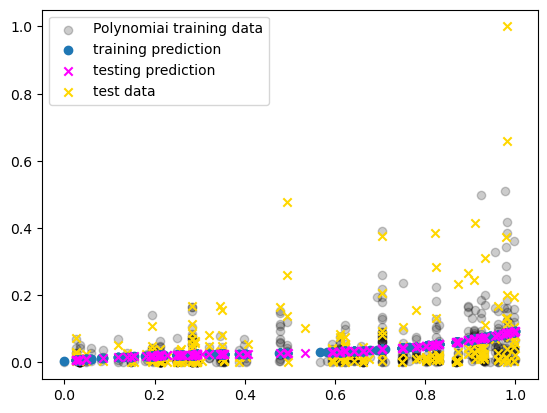

In [14]:
y_quad_fit = pr.predict(X_quad)
y_quad_fit_t = pr.predict(X_quad_t)
plt.scatter(X_train['Siedl'], y_train, label='Polynomiai training data', color='black', alpha=0.2, zorder=0)
plt.scatter(X_train['Siedl'], y_quad_fit,  label='training prediction', zorder=1)
plt.scatter(X_test['Siedl'], y_quad_fit_t, label='testing prediction', marker='x', color='magenta', zorder=2)
plt.scatter(X_test['Siedl'], y_test, label='test data', marker='x', color='gold', zorder=0)
plt.legend()
plt.show()

### Random forest

From [scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html#sklearn.ensemble.RandomForestRegressor)

A random forest is a meta estimator that fits a number of classifying decision trees on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting. The sub-sample size is controlled with the max_samples parameter if bootstrap=True (default), otherwise the whole dataset is used to build each tree.

In [15]:
X_train, X_test, y_train, y_test = train_test_split(df_oi, y, test_size=0.3, random_state=1)
forest = RandomForestRegressor(n_estimators=1000, criterion='squared_error', random_state=1, n_jobs=-1)
forest.fit(X_train, y_train)
y_train_pred = forest.predict(X_train)
y_test_pred = forest.predict(X_test)
model_performance.append(collect_model_results('Forest', y_test, y_test_pred))
mse = mean_squared_error(y_test, y_test_pred)
forest

RandomForestRegressor(n_estimators=1000, n_jobs=-1, random_state=1)

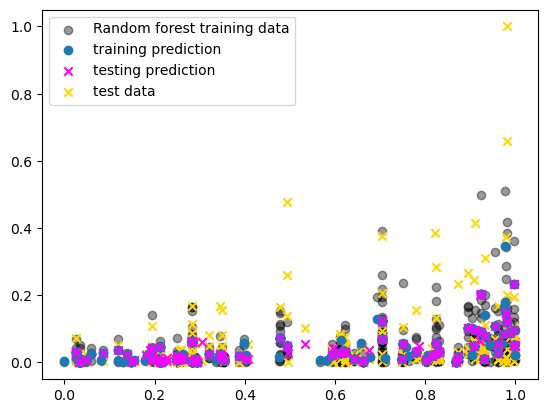

In [16]:

plt.scatter(X_train['Siedl'], y_train, label='Random forest training data', color='black', alpha=0.4, zorder=0)
plt.scatter(X_train['Siedl'], y_train_pred,  label='training prediction', zorder=1)
plt.scatter(X_test['Siedl'], y_test_pred, label='testing prediction', marker='x', color='magenta', zorder=2)
plt.scatter(X_test['Siedl'], y_test, label='test data', marker='x', color='gold', zorder=0)
plt.legend()
plt.show()

### Compression: PCA

From [scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html)

In the context of dimensionality reduction, feature extraction can be understood as an approach to data compression with the goal of maintaining most of the relevant information. In practice, feature extraction is not only used to improve storage space or the computational efficiency of the learning algorithm but can also improve the predictive performance by reducing the noise or the curse of dimensionality. 

In [17]:
# Define the number of components for PCA
n_components = 5# Adjust this number as needed

# Create a pipeline with PCA and Linear Regression
pipeline = Pipeline([
    ('reduce_dim', PCA(n_components=n_components)),
    ('regressor', LinearRegression())
])

# # Split the data into a training and testing set
X_train, X_test, y_train, y_test = train_test_split(df_oi, y, test_size=0.3, random_state=1)

# Fit the pipeline on the training data
pipeline.fit(X_train, y_train)

# Predict on the testing data
y_test_pred = pipeline.predict(X_test)
y_train_pred = pipeline.predict(X_train)
model_performance.append(collect_model_results('PCA => Linear', y_test, y_test_pred))

# Evaluate the model
mse = mean_squared_error(y_test, y_test_pred)
pipeline

Pipeline(steps=[('reduce_dim', PCA(n_components=5)),
                ('regressor', LinearRegression())])

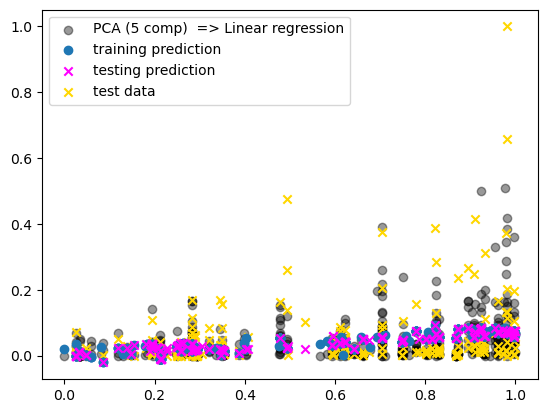

In [18]:
plt.scatter(X_train['Siedl'], y_train, label='PCA (5 comp)  => Linear regression', color='black', alpha=0.4, zorder=0)
plt.scatter(X_train['Siedl'], y_train_pred,  label='training prediction', zorder=1)
plt.scatter(X_test['Siedl'], y_test_pred, label='testing prediction', marker='x', color='magenta', zorder=2)
plt.scatter(X_test['Siedl'], y_test, label='test data', marker='x', color='gold', zorder=0)
plt.legend()
plt.show()

In [19]:
# Define the number of components for PCA
n_components = 2# Adjust this number as needed

# Define the degree of the polynomial regression
poly_degree = 2 # Adjust this as needed

# Create a pipeline with PCA, Polynomial Regression, and Linear Regression
pipeline = Pipeline([
    ('reduce_dim', PCA(n_components=n_components)),
    ('polynomial_features', PolynomialFeatures(degree=poly_degree)),
    ('regressor', LinearRegression())
])

X_train, X_test, y_train, y_test = train_test_split(df_oi, y, test_size=0.3, random_state=1)

# Fit the pipeline on the training data
pipeline.fit(X_train, y_train)

# Predict on the testing data
y_test_pred = pipeline.predict(X_test)
y_train_pred = pipeline.predict(X_train)
model_performance.append(collect_model_results('PCA => polynomial => linear', y_test, y_test_pred))

# Evaluate the model
mse = mean_squared_error(y_test, y_test_pred)
pipeline

Pipeline(steps=[('reduce_dim', PCA(n_components=2)),
                ('polynomial_features', PolynomialFeatures()),
                ('regressor', LinearRegression())])

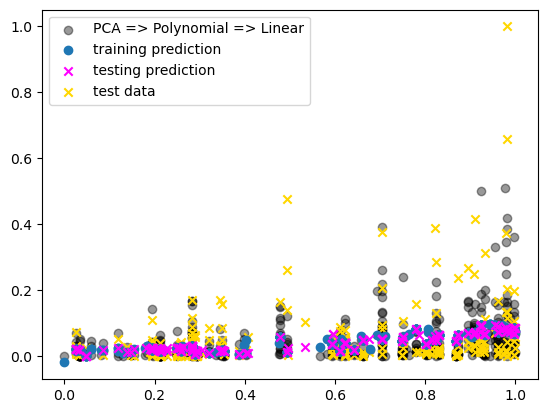

In [20]:
plt.scatter(X_train['Siedl'], y_train, label='PCA => Polynomial => Linear', color='black', alpha=0.4, zorder=0)
plt.scatter(X_train['Siedl'], y_train_pred,  label='training prediction', zorder=1)
plt.scatter(X_test['Siedl'], y_test_pred, label='testing prediction', marker='x', color='magenta', zorder=2)
plt.scatter(X_test['Siedl'], y_test, label='test data', marker='x', color='gold', zorder=0)
plt.legend()
plt.show()

### Model performance

In [21]:
data = [list(x.values())[0] for x in model_performance]
index = [list(x.keys())[0] for x in model_performance]

pd.DataFrame(data, index=index)

,MSE,r²
RANSAC-Linear,0.011185,0.042132
Forest,0.010317,0.116478
PCA => Linear,0.011003,0.057695
PCA => polynomial => linear,0.011188,0.041884


## Generalized linear models

In [22]:
# Create a Poisson regression model
poisson_model = sm.GLM(target, features, family=sm.families.NegativeBinomial(alpha=1)).fit()

# Display the model summary
print(poisson_model.summary())


                 Generalized Linear Model Regression Results                  
Dep. Variable:                 scaled   No. Observations:                  753
Model:                            GLM   Df Residuals:                      746
Model Family:        NegativeBinomial   Df Model:                            6
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -135.82
Date:                Tue, 07 Nov 2023   Deviance:                       44.155
Time:                        10:42:48   Pearson chi2:                     67.8
No. Iterations:                     5   Pseudo R-squ. (CS):            0.01682
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Obstanlage    -2.8856      2.249     -1.283      0.2

In [23]:
%watermark -a hammerdirt-analyst -co --iversions

Author: hammerdirt-analyst

conda environment: cantonal_report

scipy      : 1.11.2
statsmodels: 0.14.0
sklearn    : 1.3.0
matplotlib : 3.7.1
pandas     : 2.0.3
seaborn    : 0.12.2
numpy      : 1.25.2

